### Chatbot with Tool

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

import os
from dotenv import load_dotenv
load_dotenv()

# loading the llm
api_key = os.getenv("GROQ_API")
llm = ChatGroq(model = "gemma2-9b-it", api_key = api_key)

In [16]:
# Loading the tavily tool
from langchain_tavily import TavilySearch
tavily_api_key = os.getenv("TAVILY_API")

tool = TavilySearch(max_results = 2)
tool.invoke("What is the latest news in kerala")

{'query': 'What is the latest news in kerala',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Latest Kerala News - Mathrubhumi English',
   'url': 'https://english.mathrubhumi.com/mobile/news/kerala',
   'content': 'Mathrubhumi English delivers the latest Kerala news, breaking updates, politics, crime, entertainment, travel, food, culture, and more. Stay updated with top Kerala headlines in English.',
   'score': 0.78788257,
   'raw_content': None},
  {'title': 'Kerala News Today in English | Latest Kerala Updates - Onmanorama',
   'url': 'https://www.onmanorama.com/news/kerala.html',
   'content': 'Get all the Latest Kerala News Updates from Onmanorama. Kerala Breaking News, Kerala News in English Today, Kerala News Headlines in English, Kerala.News Kerala , Kerala Breaking News , Kerala News Headlines , Kerala News English , Kerala Political News , Kerala Crime News , Kerala English News , Kerala News Updates , Kerala Local News , Kerala',
   's

In [45]:
#Defining custom function
def multipy(a:int,b:int)->int: # the doc string is very important
    """Multiply a and b # example of document string

    Args:
        a (int) : first int
        b (int) : second int

    Returns:
        int: output int
    """
    return(a*b)

#Creating the tools list 
tools = [tool,multipy]

#binding llm with tools
llm_with_tools = llm.bind_tools(tools)

In [46]:
# Initializing  State
class State(TypedDict): #TypedDict makes sure that the return type of this class is a dictionary
    messages:Annotated[list, add_messages]

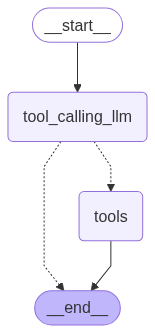

In [47]:
# Creating StateGraph and the Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# defining the tool calling llm Node function
def tool_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

# Building the graph
graph_builder = StateGraph(State)

#Adding nodes
graph_builder.add_node("tool_calling_llm",tool_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Adding edges
graph_builder.add_edge(START,"tool_calling_llm" )
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message result from assistant is a tool call --> tools_condition routes to tools
    #If the latest message result from assistant is not a tool call --> tools_condition routes to END
    tools_condition)
graph_builder.add_edge("tools",END)

#compilng the graph
graph = graph_builder.compile()
graph

# visualise the graph this way as well
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception :
    pass

In [48]:
# Calling the LLM
response1 = graph.invoke({"messages":"What is the recent news from OpenAI"})

In [ ]:
response1["messages"][-1].content

for m in response1["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent news from OpenAI
================================== Ai Message ==================================
Tool Calls:
  tavily_search (t0naq1k0y)
 Call ID: t0naq1k0y
  Args:
    query: recent news from OpenAI
    search_depth: advanced
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent news from OpenAI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "AI-Weekly for Tuesday, July 1, 2025 - Issue 171", "url": "https://ai-weekly.ai/newsletter-07-01-2025/", "content": "AI News: DeepSeek R2 Delayed, Meta Poaches From OpenAI, OpenAI Sued, Imagen 4, And More! | Matt Berman | YouTube.com | June 27, 2025 Key developments in AI include the delay of DeepSeek R2, Meta's recruitment of talent from OpenAI, and a legal challenge facing OpenAI.", "score": 0.8170061, "raw_content": null}, 

In [57]:
print('output_2')
response2 = graph.invoke({"messages":"What is 2 multiplied by 3"})
for m in response2["messages"]:
    m.pretty_print()

print('\noutput_3')
response3 = graph.invoke({"messages":"What is 6 multiplied by 3 and then multiply 20"})
for m in response3["messages"]:
    m.pretty_print()

print('\noutput_4')
response4 = graph.invoke({"messages":"What is the lastest OpenAI news and also multipy 3 and 20"})
for m in response4["messages"]:
    m.pretty_print()

output_2
================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multipy (kvpr4691p)
 Call ID: kvpr4691p
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multipy

6

output_3
================================ Human Message =================================

What is 6 multiplied by 3 and then multiply 20
================================== Ai Message ==================================
Tool Calls:
  multipy (2cfx7h38f)
 Call ID: 2cfx7h38f
  Args:
    a: 18
    b: 20
================================= Tool Message =================================
Name: multipy

360

output_4
================================ Human Message =================================

What is the lastest OpenAI news and also multipy 3 and 20
================================== Ai Message ==========================

## ReAct Agent Architecture

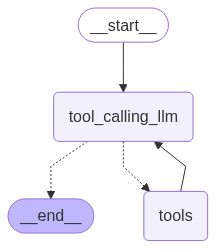

In [65]:
# Implementing ReAct Agent Architecture

# Creating StateGraph and the Graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# defining the tool calling llm Node function
def tool_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

# Building the graph
graph_builder = StateGraph(State)

#Adding nodes
graph_builder.add_node("tool_calling_llm",tool_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Adding edges
graph_builder.add_edge(START,"tool_calling_llm" )
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message result from assistant is a tool call --> tools_condition routes to tools
    #If the latest message result from assistant is not a tool call --> tools_condition routes to END
    tools_condition)
graph_builder.add_edge("tools","tool_calling_llm")
# graph_builder.add_edge("tools",END)

#compilng the graph
graph_react = graph_builder.compile()
graph_react

# visualise the graph this way as well
from IPython.display import Image, display

try:
    display(Image(graph_react.get_graph().draw_mermaid_png()))

except Exception :
    pass

In [72]:
print('output_2')
response2 = graph_react.invoke({"messages":"What is 2 multiplied by 3"})
for m in response2["messages"]:
    m.pretty_print()

print('\noutput_3')
response3 = graph_react.invoke({"messages":"What is 6 multiplied by 3 and then multiply 20"})
for m in response3["messages"]:
    m.pretty_print()

print('\noutput_4')
response4 = graph_react.invoke({"messages":"What is the 5 lastest news in AI and also multipy 3 and 20. Also give me the latest news of AI in India"})
for m in response4["messages"]:
    m.pretty_print()

output_2
================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multipy (hhqz8h122)
 Call ID: hhqz8h122
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multipy

6
================================== Ai Message ==================================

6

output_3
================================ Human Message =================================

What is 6 multiplied by 3 and then multiply 20
================================== Ai Message ==================================
Tool Calls:
  multipy (qgcdk089p)
 Call ID: qgcdk089p
  Args:
    a: 18
    b: 20
================================= Tool Message =================================
Name: multipy

360
================================== Ai Message ==================================
Tool Calls:
  multipy (yxrk482ba)
 Call ID: yxrk482ba
  A